In [67]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "CPU"
)

env = gym.make('CartPole-v1')
state = env.reset()

In [72]:
class PID(nn.Module) : 
    def __init__(self,objective,fifo_depth=50):
        super(PID, self).__init__()
        self.obj= objective
        self.fifo_depth = fifo_depth
        self.errors = [0.]*self.fifo_depth
        self.layer1 = nn.Linear(3, 1)
        #self.layer2 = nn.Linear(1, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x=self.layer1(x)
        #x=self.layer2(x)
        #x=x*1000.
        return F.sigmoid(x)
        
    def eval(self,sense):
        self.errors.pop(0)
        self.errors.append(sense-self.obj)
        # last element in errors list is the latest
        # sum(errors) is the integral over the last fifo_depth sensor readings
        x = [[self.errors[self.fifo_depth-1],sum(self.errors),self.errors[self.fifo_depth-1]-self.errors[self.fifo_depth-2]]]
        #return int(self.forward(torch.Tensor(x).cuda()).item()>0)
        return self.forward(torch.Tensor(x).cuda()).item()

In [73]:
pid = PID(0.).to(device)
pid.eval(0.309)

#pid.layer2.weight[0][0]
#pid.eval(0.1)


0.27945515513420105

In [74]:
## optimization utilities
# Initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(pid.parameters(), lr=0.001, amsgrad=True)



Steps: 9   Total Reward: 9.0
Steps: 10   Total Reward: 10.0
Steps: 10   Total Reward: 10.0
Steps: 9   Total Reward: 9.0
Steps: 9   Total Reward: 9.0
Steps: 10   Total Reward: 10.0
Steps: 10   Total Reward: 10.0
Steps: 9   Total Reward: 9.0
Steps: 10   Total Reward: 10.0
Steps: 9   Total Reward: 9.0
Average reward: 9.5


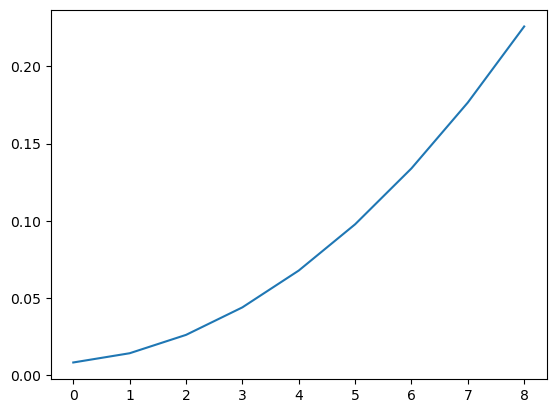

In [77]:
avg_reward = []
outputs = torch.empty(size=(1,1))
targets = torch.empty(size=(1,1))
losses = []
for i in range(10):
    obs,info = env.reset()
    obs = torch.Tensor(obs.reshape((1,4)))
    tot_reward = 0
    history = []
    term = False
    debug_print = False
    step_num = 0 
    while not term : 
        action = int(pid.eval(obs[0][2].item()))
        obs,reward,term,trun,info = env.step(action)
        obs = torch.Tensor(obs.reshape((1,4)))
        tot_reward = tot_reward+reward
        history.append(obs[0][2].item())
        if debug_print :
            print("obs:",obs)
            print("reward:",reward)
            print("term:",term)
            print("angle:",obs[0][2].item())
            print("action:",action)
        step_num = step_num+1
        if step_num : 
            outputs  = torch.cat(( outputs.cuda(), torch.Tensor([[obs[0][2].item()]]).cuda() ))
            targets = torch.cat(( targets.cuda(), torch.Tensor([[0.]]).cuda() )) 
        else : 
            outputs  = obs[2]
            targets = torch.Tensor([[0.]])
    avg_reward.append(tot_reward)
    print("Steps: {0}   Total Reward: {1}".format(len(history),tot_reward))   
    loss = criterion(outputs.cuda(), targets.cuda())

    # Optimize the model
    #optimizer.zero_grad()
    #loss.backward()
    # In-place gradient clipping
    #torch.nn.utils.clip_grad_value_(surrogate.parameters(), 100)
    #optimizer.step()
    #print(loss.item())
    #losses.append(loss.item())
#
print("Average reward:",sum(avg_reward)/10.)
plt.plot(range(len(history)),history)
plt.show()